In [38]:
import numpy as np
import pandas as pd
from astropy.time import Time
import h5py
from pycbc.conversions import mchirp_from_mass1_mass2,primary_mass,secondary_mass
from pycbc.conversions import chi_eff
import pylab,os,shutil

In [39]:
threeogc = h5py.File('/work/yifan.wang/3ogcPE/datarelease/3-ogc.hdf','r')
fourogc = h5py.File('/work/ahnitz/WWW/4ogc/4-ogc.hdf')

# Some differences between 3-ogc and 4-ogc

In [59]:
def printevent(ogc=threeogc,name=b'190601_211804'):
    ii = np.where(ogc['name'][:]==name)
    for key in ogc:
        print(key, ogc[key][ii])

In [60]:
printevent(ogc=fourogc)

H1_chisq [-0.]
H1_end_time [1.2434591e+09]
H1_sg_chisq [1.]
H1_snr [5.01440191]
L1_chisq [2.3875462]
L1_end_time [1.2434591e+09]
L1_sg_chisq [1.]
L1_snr [5.5668273]
V1_chisq [-1.]
V1_end_time [-1.]
V1_sg_chisq [-1.]
V1_snr [-1.]
ifar [2.20065893e-05]
mass1 [1.4027491]
mass2 [1.37993048]
name [b'190601_211804']
obs [b'HLV']
pastro [-1.]
spin1z [0.04756401]
spin2z [0.04611799]
stat [5.69016743]
time [1.2434591e+09]
trig [b'HL']


In [61]:
printevent(ogc=threeogc)

H1_chisq [-0.]
H1_end_time [1.2434591e+09]
H1_sg_chisq [1.]
H1_snr [5.014402]
L1_chisq [2.3875463]
L1_end_time [1.2434591e+09]
L1_sg_chisq [1.]
L1_snr [5.5668273]
V1_end_time [-1.]
ifar [2.2006589e-05]
mass1 [1.4027491]
mass2 [1.3799305]
name [b'190601_211804']
obs [b'HLV']
pastro [-1.]
spin1z [0.04756401]
spin2z [0.04611799]
stat [5.6901674]
time [1.2434591e+09]
trig [b'HL']


In [62]:
np.size(threeogc['name'][:]),np.size(fourogc['name'][:])

(3739087, 6681661)

In [63]:
fourogc.keys()

<KeysViewHDF5 ['H1_chisq', 'H1_end_time', 'H1_sg_chisq', 'H1_snr', 'L1_chisq', 'L1_end_time', 'L1_sg_chisq', 'L1_snr', 'V1_chisq', 'V1_end_time', 'V1_sg_chisq', 'V1_snr', 'ifar', 'mass1', 'mass2', 'name', 'obs', 'pastro', 'spin1z', 'spin2z', 'stat', 'time', 'trig']>

# Select those interesting triggers

In [64]:
# convert the GW events name to UTF-8 format
gwfile = fourogc
gwobs = np.array([obs.decode("utf-8") for obs in gwfile['trig'][:]])

#mass
max_mchirp = mchirp_from_mass1_mass2(2,2)
min_mchirp = mchirp_from_mass1_mass2(1,1)
mc = mchirp_from_mass1_mass2(gwfile['mass1'][:], gwfile['mass2'][:])
#lmass = (mc > min_mchirp) & (mc < max_mchirp)
mass1 = primary_mass(gwfile['mass1'][:],gwfile['mass2'][:])
mass2 = secondary_mass(gwfile['mass1'][:],gwfile['mass2'][:])
#lmass = (mass2>=1) & (mass2<=2) & (mass1<=2)
lmass = (mass2<=2)

#spin
spin = chi_eff(gwfile['mass1'][:], gwfile['mass2'][:],gwfile['spin1z'][:], gwfile['spin2z'][:])
lspin = (spin<0.2) & (spin>-0.2)

#at least two detectors
# This doesn't affect the results because single detector trigger doesn't have a IFAR
ltrig = (gwobs == 'HL') | (gwobs == 'HLV') | (gwobs == 'LV') | (gwobs == 'HV')
#ltrig = True

#false alarm rate < every 10 min
yr2min = 365.25*24*60
lifar = (gwfile['ifar'][:] > 1/yr2min * 10)

# time during O3a start and 2019 07, 02 00:00:00
ltime = (gwfile['time'][:] > Time('2019-04-01T00:00:00').gps) & (gwfile['time'][:] < Time('2019-07-02T00:00:00').gps)
l = lmass & lspin & ltrig & lifar & ltime
print('There are ', l.sum(), ' triggers')

# the index of a qualified GW event
gwidx = np.where(l)[0]

There are  3063  triggers


# FRB

In [126]:
#FRB file: CHIME FRB catalog 1
frb = pd.read_csv('/work/yifan.wang/em/gitrepo/chimefrbcat1.csv')
# convert the mjd_inf time to a datetime64 format
frb_t =  Time(frb['mjd_inf'][:],format='mjd').datetime64

tO3_start = Time('2019-04-01T00:00:00')
tO3_end = Time('2019-09-30T23:59:59')
frb = frb[(frb_t <tO3_end) & (frb_t > tO3_start) & (frb['repeater_name'] == '-9999')] #not a repeated FRB

In [127]:
frb

tns_name previous_name repeater_name      ra  ra_err ra_notes    dec  \
406  FRB20190401A         -9999         -9999  196.80    0.19    -9999  79.91   
407  FRB20190402A         -9999         -9999  178.61    0.23    -9999  47.10   
408  FRB20190403G         -9999         -9999   81.74    0.22    -9999  25.78   
409  FRB20190403A         -9999         -9999  116.33    0.24    -9999  86.36   
410  FRB20190403B         -9999         -9999  135.47    0.18    -9999   1.46   
..            ...           ...           ...     ...     ...      ...    ...   
595  FRB20190701A         -9999         -9999  277.47    0.21    -9999  59.04   
596  FRB20190701B         -9999         -9999  302.93    0.22    -9999  80.18   
597  FRB20190701C         -9999         -9999   96.36    0.23    -9999  81.63   
598  FRB20190701D         -9999         -9999  112.10    0.18    -9999  66.70   
599  FRB20190701E         -9999         -9999  138.57    0.19    -9999  61.71   

     dec_err dec_notes      gl  ...  sp_idx_err  sp_run  sp_run_err high_freq  \
406    0.210     -9999  122.07  ...        0.85    -4.1         1.3     800.2   
407    0.220     -9999  148.44  ...        2.60   -16.7         6.3     657.4   
408    0.250     -9999  180.44  ...        6.30   -76.0        13.0     603.2   
409    0.290     -9999  126.94  ...        1.60    -8.9         2.5     800.2   
410    0.090     -9999  227.76  ...        1.10   -11.1         1.9     714.3   
..       ...       ...     ...  ...         ...     ...         ...       ...   
595    0.220     -9999   88.29  ...        1.50     3.3         1.9     800.2   
596    0.240     -9999  112.88  ...        1.70   -11.8         3.1     732.8   
597    0.270     -9999  132.18  ...        9.00  -211.0        41.0     495.5   
598    0.160     -9999  149.28  ...        0.75   -20.9         1.6     651.8   
599    0.036     -9999  153.27  ...        1.40    -5.1         2.2     800.2   

     low_freq  peak_freq      chi_sq     dof  flag_frac  excluded_flag  
406     400.2      479.1  531748.797  529866      0.433              0  
407     400.2      453.3  586927.640  582762      0.376              0  
408     425.5      506.6  448191.356  446874      0.282              0  
409     400.2      513.6  362788.787  360538      0.421              0  
410     400.2      453.2  881211.496  878553      0.436              0  
..        ...        ...         ...     ...        ...            ...  
595     400.2      800.2  341779.300  341690      0.451              0  
596     400.2      471.5  329229.311  330137      0.470              0  
597     402.2      446.4  285697.192  286362      0.540              0  
598     400.2      467.6  358566.724  354457      0.431              0  
599     400.2      410.3  359241.191  356889      0.427              0  

[160 rows x 55 columns]

### There are 160 FRB events satisfying our selection

### RA,DEC distribution

In [66]:
ra_frb = np.array(frb['ra'])/ 180 * np.pi
dec_frb = np.array(frb['dec']) / 180 * np.pi

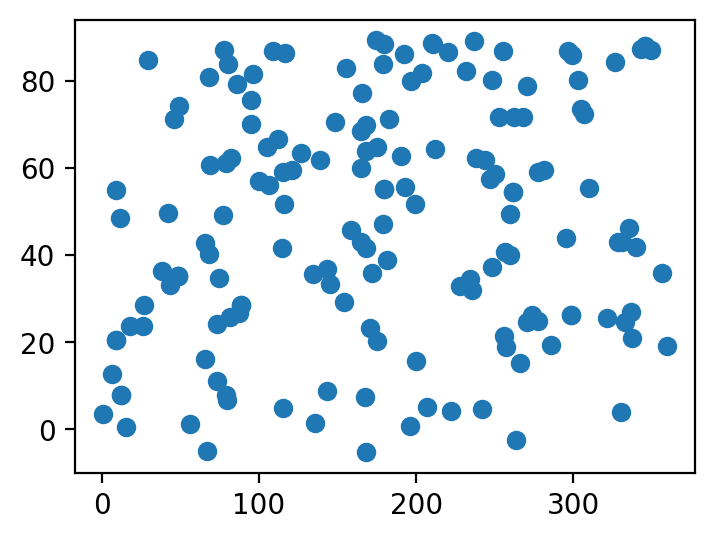

In [67]:
pylab.figure(figsize=[4,3],dpi=200)
pylab.scatter(frb['ra'],frb['dec'])

In [109]:
#add a new column called 'gpstime'
frb['gpstime'] = Time(frb['mjd_inf'][:],format='mjd').gps
t_frb = np.array(frb['gpstime'])
name_frb = np.array(frb['tns_name'])

# GW info
t_gw = gwfile['time'][gwidx]
name_gw = gwfile['name'][gwidx]
mass1_gw = gwfile['mass1'][gwidx]
mass2_gw = gwfile['mass2'][gwidx]
spin1z_gw = gwfile['spin1z'][gwidx]
spin2z_gw = gwfile['spin2z'][gwidx]
ifar_gw = gwfile['ifar'][gwidx]

# Time window [-600,3600]

In [125]:
name_frb[97:99]

array(['FRB20190601C', 'FRB20190601C'], dtype=object)

In [115]:
#[t_frb ---600s--- t_gw ----------- 3600s ------------- t_gw]
frb_left_index = np.searchsorted(t_frb, t_gw - 600)
frb_right_index = np.searchsorted(t_frb, t_gw + 3600)

#t_frb > t_gw-10 while t_frb > t_gw+3600
max_cogwfrb = np.max(frb_right_index - frb_left_index)
i=1
#max_cogwfrb=1
while i  <= max_cogwfrb:
    co_idx = np.where((frb_right_index - frb_left_index) == i)[0]
    print(i,co_idx)
    if i==1:
        gw_co_idx = co_idx 
        frb_co_idx = frb_left_index[co_idx]
    else:
        for j in range(i):
            gw_co_idx = np.append(gw_co_idx ,  co_idx )
            frb_co_idx = np.append( frb_co_idx ,frb_left_index[co_idx]+j )
    i = i+1

print('There are ', len(gw_co_idx), 'coincidence.')

1 [  42   43   44   48   60   61   66   73   74   88   89   90   91  132
  133  235  250  251  255  256  267  268  285  300  302  303  304  305
  350  351  419  451  459  495  496  539  540  565  566  570  571  573
  589  590  655  660  747  748  765  773  849  850  859  860  861  862
  887  888  889  890  978  979  980  981  999 1000 1001 1002 1003 1455
 1456 1462 1502 1503 1504 1508 1514 1515 1516 1517 1522 1542 1543 1564
 1565 1569 1570 1571 1572 1573 1579 1580 1581 1582 1597 1598 1950 1951
 1952 1958 1974 1975 1976 1985 1986 1987 2007 2008 2009 2010 2066 2067
 2108 2120 2123 2124 2125 2126 2127 2131 2132 2133 2134 2135 2154 2155
 2200 2201 2202 2203 2204 2228 2275 2276 2277 2281 2286 2287 2288 2289
 2348 2357 2358 2380 2381 2382 2406 2418 2442 2443 2444 2445 2526 2568
 2585 2586 2587 2597 2598 2619 2620 2630 2631 2634 2635 2643 2644 2684
 2685 2686 2687 2688 2694 2695 2696 2729 2760 2761 2771 2772 2773 2774
 2776 2777 2778 2779 2780 2815 2816 2833 2834 2835 2836 2837 2876 2877
 287

In [116]:
gw_co_idx

array([  42,   43,   44,   48,   60,   61,   66,   73,   74,   88,   89,
         90,   91,  132,  133,  235,  250,  251,  255,  256,  267,  268,
        285,  300,  302,  303,  304,  305,  350,  351,  419,  451,  459,
        495,  496,  539,  540,  565,  566,  570,  571,  573,  589,  590,
        655,  660,  747,  748,  765,  773,  849,  850,  859,  860,  861,
        862,  887,  888,  889,  890,  978,  979,  980,  981,  999, 1000,
       1001, 1002, 1003, 1455, 1456, 1462, 1502, 1503, 1504, 1508, 1514,
       1515, 1516, 1517, 1522, 1542, 1543, 1564, 1565, 1569, 1570, 1571,
       1572, 1573, 1579, 1580, 1581, 1582, 1597, 1598, 1950, 1951, 1952,
       1958, 1974, 1975, 1976, 1985, 1986, 1987, 2007, 2008, 2009, 2010,
       2066, 2067, 2108, 2120, 2123, 2124, 2125, 2126, 2127, 2131, 2132,
       2133, 2134, 2135, 2154, 2155, 2200, 2201, 2202, 2203, 2204, 2228,
       2275, 2276, 2277, 2281, 2286, 2287, 2288, 2289, 2348, 2357, 2358,
       2380, 2381, 2382, 2406, 2418, 2442, 2443, 24

In [117]:
frb_co_idx

array([  3,   3,   3,   4,   5,   5,   6,   9,   9,  10,  10,  10,  10,
        11,  11,  13,  14,  14,  15,  15,  16,  16,  19,  20,  21,  21,
        21,  21,  24,  24,  27,  29,  32,  33,  33,  36,  36,  37,  37,
        38,  38,  39,  40,  40,  41,  42,  53,  53,  54,  55,  56,  56,
        57,  57,  57,  57,  58,  58,  58,  58,  65,  65,  65,  65,  67,
        67,  67,  67,  67,  68,  68,  71,  72,  72,  72,  73,  74,  74,
        74,  74,  76,  77,  77,  81,  81,  82,  82,  82,  82,  82,  83,
        83,  83,  83,  84,  84,  90,  90,  90,  91,  93,  93,  93,  94,
        94,  94,  95,  95,  95,  95,  99,  99, 100, 102, 103, 103, 103,
       103, 103, 104, 104, 104, 104, 104, 105, 105, 107, 108, 108, 108,
       108, 109, 112, 112, 112, 113, 114, 114, 114, 114, 115, 116, 116,
       117, 117, 117, 118, 119, 122, 122, 122, 122, 123, 124, 125, 125,
       125, 126, 126, 127, 127, 128, 128, 129, 129, 130, 130, 132, 133,
       133, 133, 133, 134, 134, 134, 135, 136, 136, 137, 137, 13

# Verification

In [118]:
len(gw_co_idx), len(t_gw[gw_co_idx])

(244, 244)

In [119]:
len(frb_co_idx), len(t_frb[frb_co_idx])

(244, 244)

(array([23., 21., 22., 22., 25., 29., 24., 29., 23., 26.]),
 array([-595.69010997, -179.4476193 ,  236.79487138,  653.03736205,
        1069.27985272, 1485.5223434 , 1901.76483407, 2318.00732474,
        2734.24981542, 3150.49230609, 3566.73479676]),
 <BarContainer object of 10 artists>)

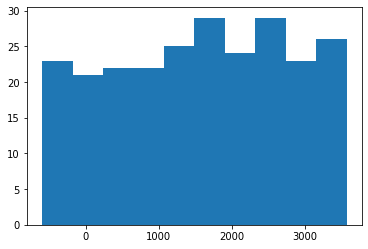

In [121]:
pylab.hist(t_frb[frb_co_idx] - t_gw[gw_co_idx])

# Output the coincident triggers

In [122]:
import pandas as pd
gwfrb_dict = {
        'frb_name': name_frb[frb_co_idx],
            'gwname': gwfile['name'][gwidx][gw_co_idx],
            'mass1': gwfile['mass1'][gwidx][gw_co_idx],
            'mass2': gwfile['mass2'][gwidx][gw_co_idx],
            'spin1z': gwfile['spin1z'][gwidx][gw_co_idx],
            'spin2z':gwfile['spin2z'][gwidx][gw_co_idx],
    'ra': ra_frb[frb_co_idx],
    'dec': dec_frb[frb_co_idx],
    'frb_minus_gw_time': t_frb[frb_co_idx] - gwfile['time'][gwidx][gw_co_idx],
    'frb_time':t_frb[frb_co_idx],
    'gw_time':gwfile['time'][gwidx][gw_co_idx],
    'ifar':gwfile['ifar'][gwidx][gw_co_idx],
    'H1_snr':gwfile['H1_snr'][gwidx][gw_co_idx],
    'H1_chisq':gwfile['H1_chisq'][gwidx][gw_co_idx],
    'L1_snr':gwfile['L1_snr'][gwidx][gw_co_idx],
    'L1_chisq':gwfile['L1_chisq'][gwidx][gw_co_idx],
    'V1_snr':gwfile['V1_snr'][gwidx][gw_co_idx],
    'V1_chisq':gwfile['V1_chisq'][gwidx][gw_co_idx],
    'obs': gwfile['obs'][gwidx][gw_co_idx],
    'trig': gwfile['trig'][gwidx][gw_co_idx],
            
          }

df = pd.DataFrame(gwfrb_dict)
df.to_csv('gwfrb-trigger-corrected.csv')

# Make events.ini. 
## First, fix_sky

In [72]:
fixskydir = '/work/yifan.wang/em/workflow/t2-dynesty-4ogc/fix_sky/triggers/'
try:
    shutil.rmtree(fixskydir)
except FileNotFoundError:
    pass

os.mkdir(fixskydir)
itrig = 0

for ii,vv in enumerate(gw_co_idx):
    print('#########################')
    print('Trigger from GRB/GW search: ',name_gw[vv])
    with open(fixskydir + 'trigger_'+str(itrig)+'_fixsky.ini', 'w') as t:
        #This line can't be cut into multiple lines or if fails with "string format" issues
        t.write('[trigger]\nmass1=%f\nmass2=%f\nspin1z=%f\nspin2z=%f\nra=%f\ndec=%f\ntrigger_time=%f' % 
                (mass1_gw[vv],
                 mass2_gw[vv],
                 spin1z_gw[vv],
                 spin2z_gw[vv],
                 #the iith frb_co_idx
                 #vv = gw_co_idx(ii)
                 ra_frb[frb_co_idx[ii]],dec_frb[frb_co_idx[ii]],
                 t_gw[vv])
               )
        t.close()
        itrig  +=1

#########################
Trigger from GRB/GW search:  b'190401_153439'
#########################
Trigger from GRB/GW search:  b'190401_160758'
#########################
Trigger from GRB/GW search:  b'190401_170119'
#########################
Trigger from GRB/GW search:  b'190401_183722'
#########################
Trigger from GRB/GW search:  b'190401_183747'
#########################
Trigger from GRB/GW search:  b'190401_184509'
#########################
Trigger from GRB/GW search:  b'190401_191139'
#########################
Trigger from GRB/GW search:  b'190401_192126'
#########################
Trigger from GRB/GW search:  b'190401_194222'
#########################
Trigger from GRB/GW search:  b'190401_195046'
#########################
Trigger from GRB/GW search:  b'190401_201246'
#########################
Trigger from GRB/GW search:  b'190401_210443'
#########################
Trigger from GRB/GW search:  b'190401_213744'
#########################
Trigger from GRB/GW search:  b'190401_

Trigger from GRB/GW search:  b'190405_095208'
#########################
Trigger from GRB/GW search:  b'190405_100703'
#########################
Trigger from GRB/GW search:  b'190405_105157'
#########################
Trigger from GRB/GW search:  b'190405_105633'
#########################
Trigger from GRB/GW search:  b'190405_121706'
#########################
Trigger from GRB/GW search:  b'190405_122050'
#########################
Trigger from GRB/GW search:  b'190405_122947'
#########################
Trigger from GRB/GW search:  b'190405_131823'
#########################
Trigger from GRB/GW search:  b'190405_133720'
#########################
Trigger from GRB/GW search:  b'190405_141404'
#########################
Trigger from GRB/GW search:  b'190405_145411'
#########################
Trigger from GRB/GW search:  b'190405_152203'
#########################
Trigger from GRB/GW search:  b'190405_154243'
#########################
Trigger from GRB/GW search:  b'190405_161223'
##################

In [73]:
for i in ['mass1','mass2','spin1z','spin2z','time']:
    print(gwfile[i][gwidx][gw_co_idx[217]])

1.0651624780428472
1.260621210878704
-0.042376149752554514
-0.03613959983732239
1245766372.3737793


In [75]:
ra_frb[frb_co_idx[217]], dec_frb[frb_co_idx[217]]

(0.20106192982974677, 0.8480554835440448)

In [76]:
eventdir = '/work/yifan.wang/em/workflow/t2-dynesty-4ogc/fix_sky/events.ini'

try:
    os.remove(eventdir)
except FileNotFoundError:
    pass
ievent = 0
with open(eventdir, 'w') as t:
    
    for ii in gw_co_idx:
        print('#########################')
        print('Trigger from GRB/GW search: ',name_gw[ii])
        t.write('[event-'+str(name_gw[ii].decode())+']\nlabel='+str(name_gw[ii].decode())+'-'+str(ievent)+'\nconfig-files=fixsky_inference.ini\n\t\to3a.ini\n\t\ttriggers/trigger_'+str(ievent)+'_fixsky.ini\n\n')
        ievent = ievent+1
t.close()

#########################
Trigger from GRB/GW search:  b'190403_015506'
#########################
Trigger from GRB/GW search:  b'190403_020441'
#########################
Trigger from GRB/GW search:  b'190403_023933'
#########################
Trigger from GRB/GW search:  b'190403_035529'
#########################
Trigger from GRB/GW search:  b'190403_111054'
#########################
Trigger from GRB/GW search:  b'190403_111922'
#########################
Trigger from GRB/GW search:  b'190403_162824'
#########################
Trigger from GRB/GW search:  b'190404_041922'
#########################
Trigger from GRB/GW search:  b'190404_042729'
#########################
Trigger from GRB/GW search:  b'190404_114505'
#########################
Trigger from GRB/GW search:  b'190404_121518'
#########################
Trigger from GRB/GW search:  b'190404_122733'
#########################
Trigger from GRB/GW search:  b'190404_123131'
#########################
Trigger from GRB/GW search:  b'190405_

# Then relax the sky position

In [81]:
eventdir = '/work/yifan.wang/em/workflow/t2-dynesty-4ogc/relax_sky/events.ini'

try:
    os.remove(eventdir)
except FileNotFoundError:
    pass
ievent = 0
with open(eventdir, 'w') as t:
    
    for ii in gw_co_idx:
        print('#########################')
        print('Trigger from GRB/GW search: ',name_gw[ii])
        t.write('[event-'+str(name_gw[ii].decode())+']\n'+
                'label='+str(name_gw[ii].decode())+'-'+str(ievent)+'\n'+
                'config-files=relaxsky_inference.ini\n'+
                '\t/work/yifan.wang/em/workflow/t2-dynesty-4ogc/fix_sky/o3a.ini\n'+
                '\t/work/yifan.wang/em/workflow/t2-dynesty-4ogc/fix_sky/triggers/trigger_'+str(ievent)+'_fixsky.ini\n\n')
        ievent = ievent+1
t.close()

#########################
Trigger from GRB/GW search:  b'190403_015506'
#########################
Trigger from GRB/GW search:  b'190403_020441'
#########################
Trigger from GRB/GW search:  b'190403_023933'
#########################
Trigger from GRB/GW search:  b'190403_035529'
#########################
Trigger from GRB/GW search:  b'190403_111054'
#########################
Trigger from GRB/GW search:  b'190403_111922'
#########################
Trigger from GRB/GW search:  b'190403_162824'
#########################
Trigger from GRB/GW search:  b'190404_041922'
#########################
Trigger from GRB/GW search:  b'190404_042729'
#########################
Trigger from GRB/GW search:  b'190404_114505'
#########################
Trigger from GRB/GW search:  b'190404_121518'
#########################
Trigger from GRB/GW search:  b'190404_122733'
#########################
Trigger from GRB/GW search:  b'190404_123131'
#########################
Trigger from GRB/GW search:  b'190405_

In [ ]:
ifrb = []
for n in [b'190519_223219',
b'190623_113752',
b'190617_021148',
b'190518_082303',
b'190419_223729']:
    l = np.where(name_gw[gwfound][:]==n)
    print(l)
    ifrb.append(l[0][0])

In [ ]:
ifrb

In [ ]:
for i in ifrb:
    print(name_frb[frbfound][i])

In [ ]:
len(t_frb[frbfound])

In [ ]:
ifar_gw[gwfound]

In [ ]:
data = np.array(np.column_stack((name_gw[gwfound], ifar_gw[gwfound])),dtype=[('S16',float)])

In [ ]:
data

In [ ]:
import h5py
f = h5py.File('/work/yifan.wang/em/prod1/gw_triggers.hdf', 'w')
f.create_dataset('gwname', data=name_gw[gwfound])
f.create_dataset('gwifar', data=ifar_gw[gwfound])
f.create_dataset('frbname',data=name_frb[frbfound])
f.close()